In [1]:
import sys
sys.path.insert(0, '/root/conda/lib/python3.9/site-packages')

In [2]:
import logging; logging.disable(logging.WARNING)
from fastcore.all import *
from fastai.imports import *
from fastai.vision.all import *

In [3]:
from transformers import CLIPTokenizer, CLIPTextModel

tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14', torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-large-patch14', torch_dtype=torch.float16).to('cuda')

In [4]:
from diffusers import AutoencoderKL, UNet2DConditionModel

vae = AutoencoderKL.from_pretrained('stabilityai/sd-vae-ft-ema', torch_dtype=torch.float16).to('cuda')
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

In [5]:
from diffusers import LMSDiscreteScheduler

sched = LMSDiscreteScheduler(
    beta_start = 0.00085,
    beta_end = 0.012,
    beta_schedule = 'scaled_linear',
    num_train_timesteps = 1000
) 
sched

LMSDiscreteScheduler {
  "_class_name": "LMSDiscreteScheduler",
  "_diffusers_version": "0.32.2",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "steps_offset": 0,
  "timestep_spacing": "linspace",
  "trained_betas": null,
  "use_beta_sigmas": false,
  "use_exponential_sigmas": false,
  "use_karras_sigmas": false
}

In [6]:
prompt = ['a photograph of an astronaut riding a horse']
w, h = 512, 512
n_inf_steps = 70
g_scale = 7.5
bs = 1
seed = 77

In [7]:
text_input = tokenizer(
    prompt,
    padding = 'max_length',
    max_length = tokenizer.model_max_length,
    truncation = True,
    return_tensors = 'pt'
)
text_input

{'input_ids': tensor([[49406,   320,  8853,   539,   550, 18376,  6765,   320,  4558, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])}

In [8]:
text_embeddings = text_encoder(text_input['input_ids'].to('cuda'))[0].half()
text_embeddings

tensor([[[-0.3884,  0.0229, -0.0523,  ..., -0.4902, -0.3066,  0.0674],
         [ 0.0297, -1.3242,  0.3076,  ..., -0.5234,  0.9746,  0.6650],
         [ 0.4587,  0.5635,  1.6680,  ..., -1.9502, -1.2295,  0.0098],
         ...,
         [-3.0430, -0.0680, -0.1783,  ...,  0.3955, -0.0186,  0.7676],
         [-3.0547, -0.1063, -0.1935,  ...,  0.4246, -0.0188,  0.7588],
         [-2.9863, -0.0850, -0.1708,  ...,  0.4355,  0.0086,  0.7480]]],
       device='cuda:0', dtype=torch.float16, grad_fn=<NativeLayerNormBackward0>)

In [9]:
text_embeddings.shape

torch.Size([1, 77, 768])

In [10]:
uncond_inp = tokenizer(
    [''] * bs,
    max_length = tokenizer.model_max_length,
    padding = 'max_length',
    truncation = True,
    return_tensors = 'pt'
)
uncond_inp

{'input_ids': tensor([[49406, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]]), 'attention_mask': tensor([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])}

In [11]:
uncond_inp['input_ids'].shape

torch.Size([1, 77])

In [12]:
uncond_embeddings = text_encoder(uncond_inp['input_ids'].to('cuda'))[0].half()
uncond_embeddings.shape

torch.Size([1, 77, 768])

In [13]:
embs = torch.cat([uncond_embeddings, text_embeddings])

In [14]:
embs.shape

torch.Size([2, 77, 768])

In [15]:
torch.manual_seed(seed)
latents = torch.randn(bs, unet.config.in_channels, h//8, w//8)
latents.shape

torch.Size([1, 4, 64, 64])

In [16]:
latents = latents.to('cuda').half()

In [17]:
sched.set_timesteps(n_inf_steps)
sched

LMSDiscreteScheduler {
  "_class_name": "LMSDiscreteScheduler",
  "_diffusers_version": "0.32.2",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "steps_offset": 0,
  "timestep_spacing": "linspace",
  "trained_betas": null,
  "use_beta_sigmas": false,
  "use_exponential_sigmas": false,
  "use_karras_sigmas": false
}

In [18]:
latents = latents * sched.init_noise_sigma
sched.init_noise_sigma

tensor(14.6146)

In [19]:
sched.sigmas

tensor([14.6146, 13.3974, 12.3033, 11.3184, 10.4301,  9.6279,  8.9020,  8.2443,
         7.6472,  7.1044,  6.6102,  6.1594,  5.7477,  5.3709,  5.0258,  4.7090,
         4.4178,  4.1497,  3.9026,  3.6744,  3.4634,  3.2680,  3.0867,  2.9183,
         2.7616,  2.6157,  2.4794,  2.3521,  2.2330,  2.1213,  2.0165,  1.9180,
         1.8252,  1.7378,  1.6552,  1.5771,  1.5031,  1.4330,  1.3664,  1.3030,
         1.2427,  1.1852,  1.1302,  1.0776,  1.0272,  0.9788,  0.9324,  0.8876,
         0.8445,  0.8029,  0.7626,  0.7236,  0.6858,  0.6490,  0.6131,  0.5781,
         0.5438,  0.5102,  0.4770,  0.4443,  0.4118,  0.3795,  0.3470,  0.3141,
         0.2805,  0.2455,  0.2084,  0.1672,  0.1174,  0.0292,  0.0000])

In [20]:
sched.timesteps

tensor([999.0000, 984.5217, 970.0435, 955.5652, 941.0870, 926.6087, 912.1304,
        897.6522, 883.1739, 868.6957, 854.2174, 839.7391, 825.2609, 810.7826,
        796.3043, 781.8261, 767.3478, 752.8696, 738.3913, 723.9130, 709.4348,
        694.9565, 680.4783, 666.0000, 651.5217, 637.0435, 622.5652, 608.0870,
        593.6087, 579.1304, 564.6522, 550.1739, 535.6957, 521.2174, 506.7391,
        492.2609, 477.7826, 463.3044, 448.8261, 434.3478, 419.8696, 405.3913,
        390.9131, 376.4348, 361.9565, 347.4783, 333.0000, 318.5217, 304.0435,
        289.5652, 275.0869, 260.6087, 246.1304, 231.6522, 217.1739, 202.6956,
        188.2174, 173.7391, 159.2609, 144.7826, 130.3044, 115.8261, 101.3478,
         86.8696,  72.3913,  57.9130,  43.4348,  28.9565,  14.4783,   0.0000])

In [21]:
from tqdm.auto import tqdm

for i, ts in enumerate(tqdm(sched.timesteps)):
    inp = torch.cat([latents] * 2)
    inp = sched.scale_model_input(inp, ts)
    
    with torch.no_grad():
        preds = unet(inp, ts, encoder_hidden_states = embs).sample
        
    pred_uncond, pred_txt = preds.chunk(2)
    pred = pred_uncond + g_scale * (pred_txt - pred_uncond)
    
    latents = sched.step(pred, ts, latents).prev_sample

  0%|          | 0/70 [00:00<?, ?it/s]

In [22]:
with torch.no_grad(): img = vae.decode(1/0.18215*latents).sample

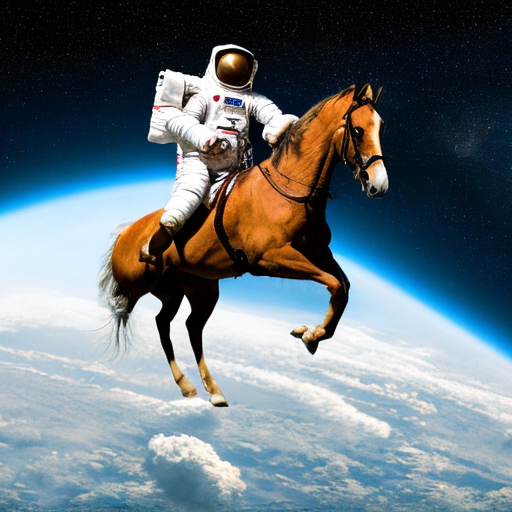

In [23]:
img = (img / 2 + 0.5).clamp(0, 1)
img = img[0].detach().cpu().permute(1, 2, 0).numpy()
img = (img * 255).round().astype('uint8')
Image.fromarray(img)

In [24]:
def tokenize(prompt, max_length = None):
    if max_length is None:
        max_length = tokenizer.model_max_length
    return tokenizer(
        prompt,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

def get_encodings(prompt, neg_prompt = None):
    text_input = tokenize(prompt)
    if neg_prompt is None:
        uncond_input = tokenize([''], max_length=text_input['input_ids'].shape[-1])
    else:
        uncond_input = tokenize(neg_prompt * len(prompt), max_length=text_input['input_ids'].shape[-1])
    
    text_embs = make_embs(text_input)
    unc_embs = make_embs(uncond_input)
    
    return torch.cat([unc_embs, text_embs])
    
def make_embs(tokenized_input):
    return text_encoder(tokenized_input['input_ids'].to('cuda'))[0].half()

In [25]:
def set_lats():
    torch.manual_seed(seed)
    lats = torch.randn(bs, unet.config.in_channels, h//8, w//8)
    sched.set_timesteps(n_inf_steps)
    lats = lats.to('cuda').half()
    return lats * sched.init_noise_sigma

In [26]:
def denoise(latents, embeddings):
    for i, ts in enumerate(tqdm(sched.timesteps)):
        #print(f"Step {i}, ts: {ts}, latents shape: {latents.shape}")
        inp = torch.cat([latents] * 2)
        inp = sched.scale_model_input(inp, ts)
        
        with torch.no_grad():
            preds = unet(inp, ts, encoder_hidden_states = embeddings).sample
            
        uncond_pred, text_pred = preds.chunk(2)
        
        pred = uncond_pred + g_scale * (text_pred - uncond_pred)
        latents = sched.step(pred, ts, latents).prev_sample
        
    return latents

def make_image(latents, embeddings):
    lats = denoise(latents, embeddings)
    with torch.no_grad(): img = vae.decode(1/0.18215*lats).sample
    
    img = (img / 2 + 0.5).clamp(0, 1)
    img = img[0].detach().cpu().permute(1, 2, 0).numpy()
    img = (img * 255).round().astype('uint8')
    return img

In [27]:
prompt = ['An antique 18th century painting of a gorilla eating a plate of chips.']
embs = get_encodings(prompt)
lats = set_lats()
img = make_image(lats, embs)

  0%|          | 0/70 [00:00<?, ?it/s]

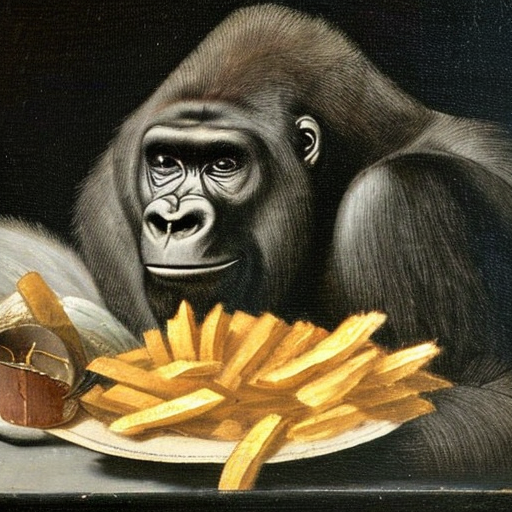

In [28]:
Image.fromarray(img)

In [29]:
prompt = ['An antique 18th century painting of a gorilla eating a plate of chips.']
neg_prompt = ['chips']
embs = get_encodings(prompt, neg_prompt)
lats = set_lats()
img = make_image(lats, embs)

  0%|          | 0/70 [00:00<?, ?it/s]

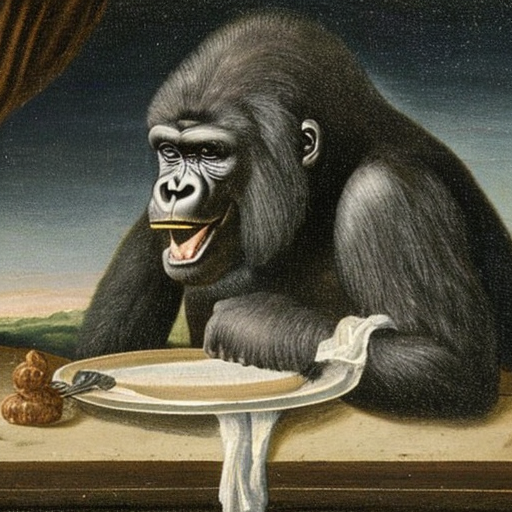

In [30]:
Image.fromarray(img)

In [91]:
class Diffusion:
    def __init__(self, prompts, neg_prompt = [''], steps = 70, g_scale = 7.5, in_channels = unet.config.in_channels, w = 512, h = 512, seed = 42):
        self.prompts = prompts
        self.bs = len(prompts)
        self.neg_prompt = neg_prompt
        self.steps = steps
        self.g = g_scale
        self.in_channels = in_channels
        self.w = w
        self.h = h
        self.seed = seed
        
    def diffuse(self):
        embs = self.get_encodings()
        lats = self.set_lats()
        return self.make_images(lats, embs)
        
    def tokenize(self, prompts, max_length = None):
        if max_length is None:
            max_length = tokenizer.model_max_length
        return tokenizer(
            prompts,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt')
    
    def get_encodings(self):
        text_input = self.tokenize(self.prompts)
        neg_input = self.tokenize(self.neg_prompt * self.bs)
    
        text_embs = self.make_embs(text_input)
        neg_embs = self.make_embs(neg_input)

        return torch.cat([neg_embs, text_embs])
    
    def make_embs(self, tokenized_input):
        return text_encoder(tokenized_input['input_ids'].to('cuda'))[0].half()
    
    def set_lats(self):
        torch.manual_seed(self.seed)
        lats = torch.randn(self.bs, self.in_channels, self.h//8, self.w//8)
        sched.set_timesteps(self.steps)
        lats = lats.to('cuda').half()
        return lats * sched.init_noise_sigma
    
    def denoise(self, latents, embeddings):
        for i, ts in enumerate(tqdm(sched.timesteps)):
            inp = torch.cat([latents] * 2)
            inp = sched.scale_model_input(inp, ts)

            with torch.no_grad():
                preds = unet(inp, ts, encoder_hidden_states = embeddings).sample

            uncond_pred, text_pred = preds.chunk(2)

            pred = uncond_pred + g_scale * (text_pred - uncond_pred)
            latents = sched.step(pred, ts, latents).prev_sample

        return latents
    
    def make_images(self, latents, embeddings):
        lats = self.denoise(latents, embeddings)
        with torch.no_grad(): imgs = vae.decode(1/0.18215*lats).sample

        imgs = (imgs / 2 + 0.5).clamp(0, 1)
        imgs = [img.detach().cpu().permute(1, 2, 0).numpy() for img in imgs]
        imgs = [(img * 255).round().astype('uint8') for img in imgs]
        return imgs
    
    def update_params(self, **kwargs):
        allowed_params = ['prompts', 'neg_prompt', 'g_scale', 'seed', 'steps', 'w', 'h']
        for k, v in kwargs.items():
            if k not in allowed_params:
                raise ValueError(f"Invalid parameter name: {k}")
            if k == 'prompts':
                self.prompts = v
                self.bs = len(v)
            else:
                setattr(self, k, v)
        

In [92]:
prompts = [
    'A lightning bolt striking a jumbo jet; 4k; photorealistic',
    'A toaster in the style of Jony Ive; modern; different; apple; form over function'
]
diffuser = Diffusion(prompts, seed=42)

In [93]:
a = diffuser.get_encodings()

In [94]:
a.shape

torch.Size([4, 77, 768])

In [95]:
imgs = diffuser.diffuse()

  0%|          | 0/70 [00:00<?, ?it/s]

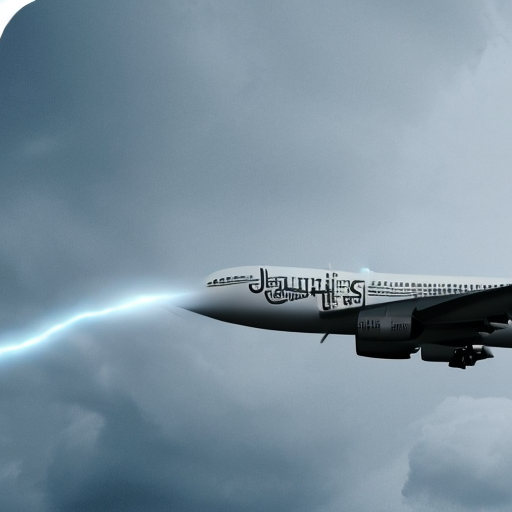

In [96]:
Image.fromarray(imgs[0])

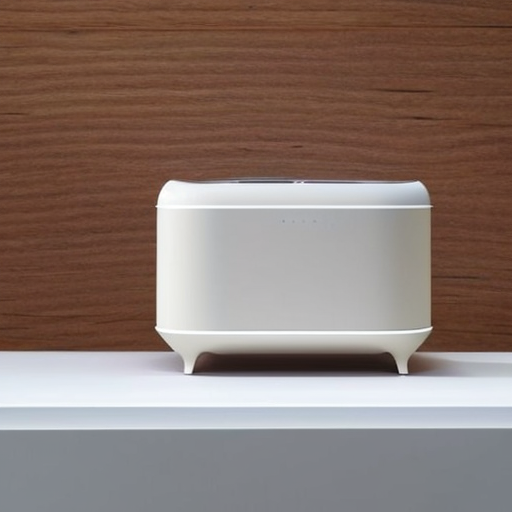

In [97]:
Image.fromarray(imgs[1])

  0%|          | 0/70 [00:00<?, ?it/s]

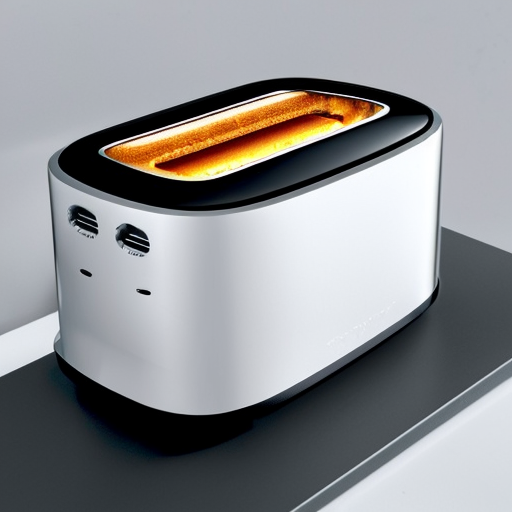

In [98]:
prompt = [prompts[1]]
diffuser.update_params(prompts=prompt, neg_prompt='wood')
Image.fromarray(diffuser.diffuse()[0])